Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at

  http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.  

# Classical Drone Classifier

In [ ]:
USING_COLAB = True
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    USING_COLAB = False

In [ ]:
import sys

if USING_COLAB is True:
    radar_path = "/content/drive/MyDrive/Radar"
else:
    radar_path = "Radar"
if radar_path not in sys.path:
    sys.path.insert(0, radar_path)
data_dir = "two_sided"
model_dir = "two_sided_models"
plot_dir = "two_sided_plots"
roc_curve_minimum = 1e-3

drone_type_map = ["DJI_Matrice_300_RTK", "DJI_Mavic_Air_2",
                  "DJI_Mavic_Mini", "DJI_Phantom_4", "Parrot_Disco"]

In [ ]:
!pip install wandb
!pip install mlxtend
!pip install torcheval

In [ ]:
import os
import torch.nn as nn
import torch
from torcheval.metrics.functional import multiclass_f1_score

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
class ClassicalRadarClassifier(nn.Module):
  def __init__(self, conf):
        super(ClassicalRadarClassifier, self).__init__()
        self._conf = conf.copy()
        # i/p shape - (batch_size, Channel_in, Height_in, Width_in) - (2, 16, 251)
        self.conv1 = nn.Conv2d(2, 16, (3,3), padding =1) # o/p shape - (16, 16, 251)
        self.IN1 = nn.InstanceNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2, padding =1) # o/p shape (16, 8, 126)
        self.conv2 = nn.Conv2d(16, 32, (5,5), padding = 2) # o/p shape (32, 8, 126)
        self.IN2 = nn.InstanceNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2) # o/p shape (32, 4, 63)
        #fully connected layers
        self.fc1 = nn.Linear( 32 * 4 * 63 , 120)
        self.fc2 = nn.Linear( 120 , 20 )
        self.fc3 = nn.Linear( 20 , 5)  # o/p shape should be (batch_size,5,1,1)
        self.drop = nn.Dropout2d(p=0.5)
        self.relu = nn.LeakyReLU()

  def forward(self, x):
        # i/p shape - (batch_size, Channel_in, Height_in, Width_in) - (2, 16, 251)
        x = self.pool1(self.relu(self.IN1(self.conv1(x))))
        x = self.drop(x)
        x = self.pool2(self.relu(self.IN2(self.conv2(x))))
        x = self.drop(x)
        #flatten
        x = torch.flatten(x, start_dim=1)
        #FC layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
import time
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as ds
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay


model_path = f"{radar_path}/{model_dir}"
plot_path = f"{radar_path}/{plot_dir}"
os.system(f"mkdir -p {model_path}")
os.system(f"mkdir -p {plot_path}")


def dataloader(file_extension):
    data = np.load(file_extension)
    return data


def plot_spectrogram(sp):
    fig, axs = plt.subplots(2, ncols=1, figsize=(14,3))

    axs[0].imshow(sp[0])
    axs[1].imshow(sp[1])

    plt.tight_layout()
    plt.show()


def plot_multiclass_roc(target, probs, snr, plot_file=None,
                        remove_zeros=False, semilog_axes=True):
    lb = LabelBinarizer().fit(target)
    one_hot_target = lb.transform(target)

    fig, ax = plt.subplots(figsize=(5, 5))
    colors = cycle(['#348ABD', '#b74331', '#8EBA42', '#FBC15E', '#988ED5'])
    for class_id, color in zip(range(5), colors):
        fpr, tpr, _ = roc_curve(one_hot_target[:,class_id], probs[:,class_id])
        if remove_zeros is True:
            zero_indices = np.where(np.isclose(fpr, 0))
            fpr = np.delete(fpr, zero_indices)
            tpr = np.delete(tpr, zero_indices)
        else:
            fpr[np.isclose(fpr,0)] = 1e-10
        display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(
            name=f"{drone_type_map[class_id]}",
            ax=ax,
            color=color)
    if semilog_axes is True:
        display.ax_.set_xscale("log")
        display.ax_.set_xlim(roc_curve_minimum, 1.0)
    display.ax_.set_xlabel("False Positive Rate")
    display.ax_.set_ylabel("True Positive Rate")
    line = plt.plot(np.geomspace(roc_curve_minimum,1.0), np.geomspace(roc_curve_minimum,1.0),
                    color='k', linestyle="dashed", label="Chance")
    display.ax_.set_title(f"ROC curves for SNR {snr}dB")
    display.ax_.legend()
    plt.tight_layout()
    if plot_file is not None:
        plt.savefig(plot_file)
    else:
        plt.show()


def train(conf, trainLoader, device):

    net = ClassicalRadarClassifier(conf).to(device)

    optim = torch.optim.AdamW(net.parameters(), lr=conf["learning_rate"])
    loss_fn = nn.CrossEntropyLoss().to(device)

    for x in range(conf["epochs"]):

        net.train()

        for i, data in enumerate(trainLoader):
            # plot_spectrogram(torch.squeeze(data[0]))
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optim.zero_grad()

            outputs = net(inputs.float())
            loss = loss_fn(outputs, labels)
            loss.backward()
            optim.step()
            loss_val = loss.item()

        print('Train Epoch: {} Loss: {:.6f}'.format(x, loss_val))
        if x > conf['min_epochs'] and loss_val < conf['loss_threshold']:
            break

    if conf['save_model'] is True:
        print(f"Saving model state to {conf['model_path']}")
        torch.save(net.state_dict(), conf['model_path'])


def test(conf, testLoader, device, plot_dir=None):

    # load model state
    net = ClassicalRadarClassifier(conf).to(device)
    net.load_state_dict(torch.load(conf['model_path']))
    net.eval()

    correct = 0
    total = 0
    testloss = 0
    predicted = None
    probabilities = None
    target = None

    loss_fn = nn.CrossEntropyLoss().to(device)

    confm = np.zeros((5, 5), dtype=int)
    for i, data in enumerate(testLoader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if target is None:
            target = labels
        else:
            target = torch.cat((target, labels))

        outputs = net(inputs.float())
        loss = loss_fn(outputs, labels)
        testloss += loss.item()

        partial_probabilities = nn.Softmax(dim=1)(outputs.data)
        if probabilities is None:
            probabilities = partial_probabilities
        else:
            probabilities = torch.cat((probabilities, partial_probabilities))

        _, partial_predicted = torch.max(outputs.data, 1)
        if predicted is None:
            predicted = partial_predicted
        else:
            predicted = torch.cat((predicted, partial_predicted))

    roc_plot_file = None
    conf_plot_file = None
    if plot_dir is not None:
        roc_plot_file = f"{plot_dir}/classical_classifier_roc_model-{model_snr}_signal-{conf['SNR']}.pdf"
        conf_plot_file = f"{plot_dir}/classical_classifier_conf_model-{model_snr}_signal-{conf['SNR']}.pdf"
    plot_multiclass_roc(target, probabilities, conf['SNR'], plot_file=roc_plot_file)

    confm = confusion_matrix(target, predicted)
    print(f"{confm=}")
    if conf['plot_confusion'] is True:
        plt.close()
        fig, ax = plot_confusion_matrix(conf_mat=confm,
                                        show_normed=True,
                                        colorbar=True,
                                        class_names=drone_type_map)
        ax.set_title(f"Confusion matrix for SNR {conf['SNR']}dB")
        plt.tight_layout()
        if conf_plot_file is not None:
            plt.savefig(conf_plot_file)
        else:
            plt.show()

    f1 = multiclass_f1_score(predicted, target, num_classes=5, average='micro')
    print(f"{f1=}")



### Run Training Code

In [ ]:

#for snr, threshold in zip([20, 15, 10, 5, 0, -5],
#                          [0.001, 0.001, 0.001, 0.01, 0.1, 0.1]):
for snr, threshold in zip([5],
                          [0.001]):
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 8
    conf['epochs'] = 200
    conf['min_epochs'] = 50
    conf['learning_rate'] = 0.001
    conf['loss_threshold'] = threshold
    conf['save_model'] = True
    conf['model_path'] = f"{model_path}/classical-data-model-{snr}.pt"

    trainset_root = f"{radar_path}/{data_dir}/trainset/{conf['f_s']}fs/{conf['SNR']}SNR"
    trainds = ds.DatasetFolder(trainset_root, dataloader, extensions=("npy",))
    trainLoader = torch.utils.data.DataLoader(trainds, conf["batch_size"], shuffle=True, num_workers=2)
    # By default the DatasetFolder assigns labels based on the alphabetically
    # sorted list of sub-folder names. Run the following code to see the
    # results.
    #
    # class_list, class_dict = trainds.find_classes(dataset_root_template)
    # print(f"{class_list=}")
    # print(f"{class_dict=}")

    print(f"SNR: {snr} dB")
    train(conf, trainLoader, device)


SNR: 5 dB
Train Epoch: 0 Loss: 1.622950
Train Epoch: 1 Loss: 1.505904
Train Epoch: 2 Loss: 1.676512
Train Epoch: 3 Loss: 1.414467
Train Epoch: 4 Loss: 1.540082
Train Epoch: 5 Loss: 1.476858
Train Epoch: 6 Loss: 0.454265
Train Epoch: 7 Loss: 0.798965
Train Epoch: 8 Loss: 0.318287
Train Epoch: 9 Loss: 0.233947
Train Epoch: 10 Loss: 0.580766
Train Epoch: 11 Loss: 0.162716
Train Epoch: 12 Loss: 0.414427
Train Epoch: 13 Loss: 0.319576
Train Epoch: 14 Loss: 0.293656
Train Epoch: 15 Loss: 0.568427
Train Epoch: 16 Loss: 0.489366
Train Epoch: 17 Loss: 0.612747
Train Epoch: 18 Loss: 0.253128
Train Epoch: 19 Loss: 0.139943
Train Epoch: 20 Loss: 0.009223
Train Epoch: 21 Loss: 0.085197
Train Epoch: 22 Loss: 0.102399
Train Epoch: 23 Loss: 0.159749
Train Epoch: 24 Loss: 0.043573
Train Epoch: 25 Loss: 0.000552
Train Epoch: 26 Loss: 0.303256
Train Epoch: 27 Loss: 0.044515
Train Epoch: 28 Loss: 0.190286
Train Epoch: 29 Loss: 0.095489
Train Epoch: 30 Loss: 0.000642
Train Epoch: 31 Loss: 0.018544
Train Ep

### Run Test Code

SNR: 20 dB
confm=array([[985,   1,   5,   6,   3],
       [  0, 986,   2,   8,   4],
       [  0,   5, 971,   5,  19],
       [  0,   9,   2, 982,   7],
       [  1,   2,   4,  23, 970]])
f1=tensor(0.9788)
SNR: 15 dB
confm=array([[964,   9,   7,  10,  10],
       [  0, 984,   1,  15,   0],
       [  2,   6, 947,  16,  29],
       [  2,   7,   2, 981,   8],
       [  6,   5,   1,  28, 960]])
f1=tensor(0.9672)
SNR: 10 dB
confm=array([[961,  13,   0,  16,  10],
       [  3, 964,   2,  27,   4],
       [  1,   6, 919,  31,  43],
       [ 11,  13,   4, 963,   9],
       [  3,  12,   0,  39, 946]])
f1=tensor(0.9506)
SNR: 5 dB
confm=array([[900,  17,   3,  57,  23],
       [ 15, 931,   4,  40,  10],
       [ 23,  17, 852,  41,  67],
       [ 34,  11,   3, 938,  14],
       [ 27,  15,   2,  63, 893]])
f1=tensor(0.9028)
SNR: 0 dB
confm=array([[856,  26,   2,  82,  34],
       [ 69, 832,   3,  69,  27],
       [ 84,  21, 699,  80, 116],
       [ 63,  19,   3, 880,  35],
       [ 85,  22,   4, 10

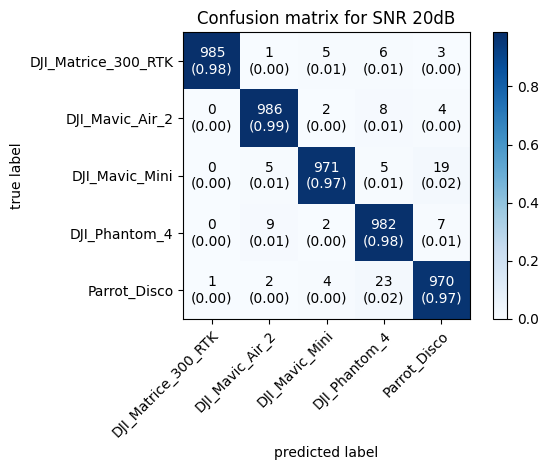

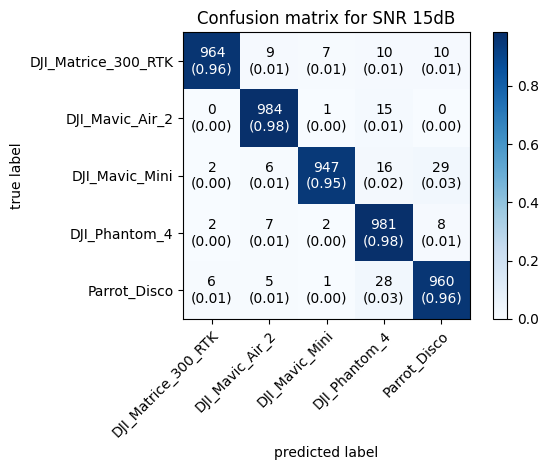

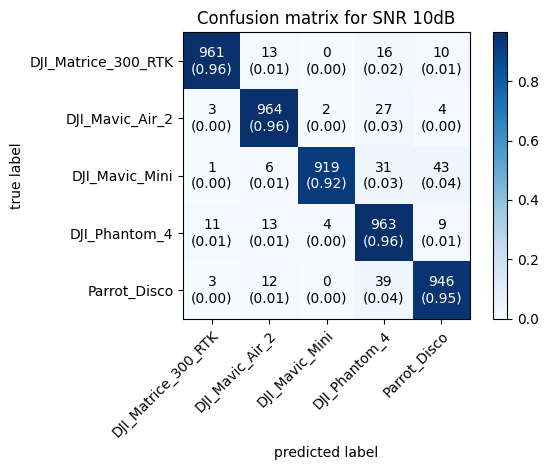

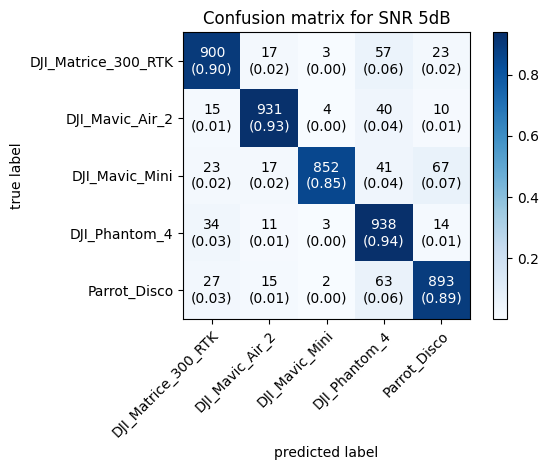

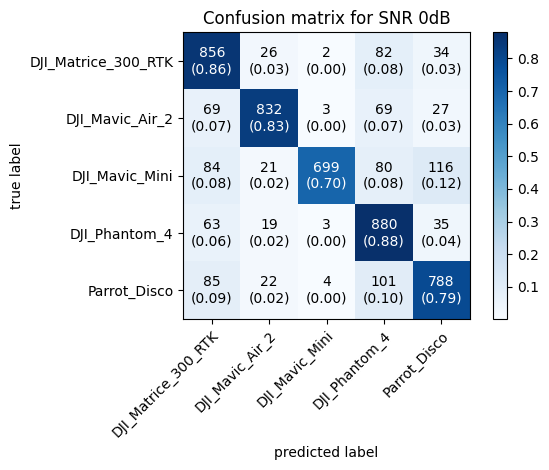

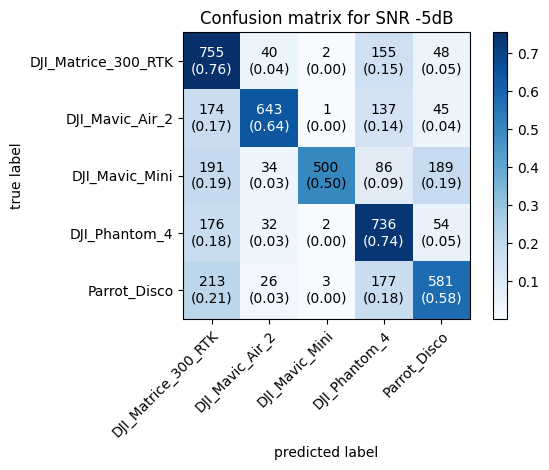

In [ ]:
model_snr = 5
for snr in [20, 15, 10, 5, 0, -5]:
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 1
    conf['epochs'] = 10
    conf['learning_rate'] = 0.0005
    conf['model_path'] = f"{model_path}/classical-data-model-{model_snr}.pt"
    conf['plot_confusion'] = True

    testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
    testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
    testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

    print(f"SNR: {snr} dB")
    test(conf, testLoader, device, plot_dir=plot_path)

### Generate Plots from Model Evaluation Results

Model evaluation for SNR=20
Model evaluation for SNR=15
Model evaluation for SNR=10
Model evaluation for SNR=5
Model evaluation for SNR=0
Model evaluation for SNR=-5



F1 Scores for Model Trained with SNR=5

Signal SNR      F1 Score
------------------------
   20   :     0.979
   15   :     0.967
   10   :     0.951
   5    :     0.903
   0    :     0.811
   -5   :     0.643





/tmp/ipykernel_3986/976266359.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3986/976266359.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


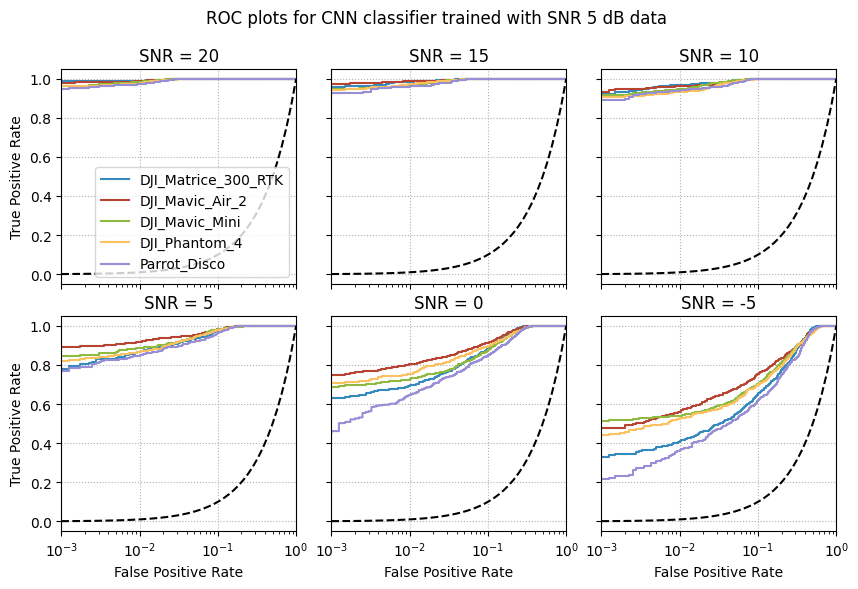

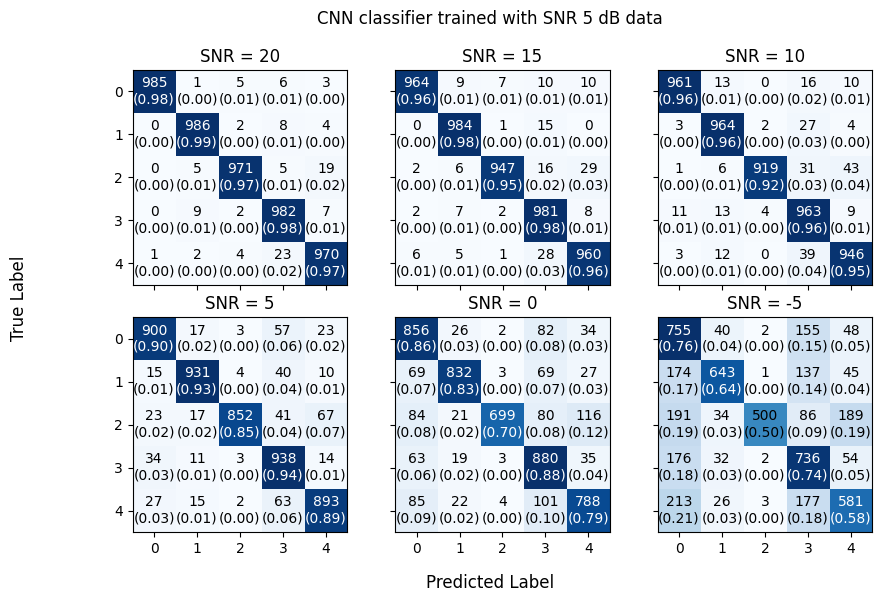

In [ ]:
from itertools import cycle

def evaluate_model(model, loader):
    target = None
    probabilities = None
    predicted = None
    testloss = 0

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if target is None:
            target = labels
        else:
            target = torch.cat((target, labels))

        outputs = model(inputs.float())
        loss = loss_fn(outputs, labels)
        testloss += loss.item()

        partial_probabilities = nn.Softmax(dim=1)(outputs.data)
        if probabilities is None:
            probabilities = partial_probabilities
        else:
            probabilities = torch.cat((probabilities, partial_probabilities))

        _, partial_predicted = torch.max(outputs.data, 1)

        if predicted is None:
            predicted = partial_predicted
        else:
            predicted = torch.cat((predicted, partial_predicted))
    return target, predicted, probabilities


def calc_model_f1_scores(pred, real):
    f1_scores = {}
    for idx, snr in enumerate(test_snrs):
        f1_scores[snr] = float(multiclass_f1_score(pred[idx], real[idx], num_classes=5, average='micro').numpy())
    return f1_scores


def print_f1_scores(mdl_snr, pred, real):
    f1_scores = calc_model_f1_scores(pred, real)

    print("\n\n")
    print(f"F1 Scores for Model Trained with SNR={mdl_snr}\n")
    print("Signal SNR      F1 Score")
    print("------------------------")
    for snr, f1 in f1_scores.items():
        print(f"{snr:^8}:     {f1:.3f}")
    print("\n\n")


def plot_confusion_matrices(mdl_snr, snrs, pred, real):
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(nrows=2, ncols=3, hspace=0.15, wspace=0.05)
    axs = gs.subplots(sharex='col', sharey='row')
    for idx, snr in enumerate(confusion_snrs):
        col = idx % 3
        row = idx // 3
        confm = confusion_matrix(target[idx], predicted[idx])
        plot_confusion_matrix(conf_mat=confm,
                              figure=fig,
                              axis=axs[row, col],
                              show_normed=True,
                              colorbar=False)
        axs[row, col].set_title(f"SNR = {snr}")
        axs[row, col].label_outer()
    axs[1,2].set_xlabel("")
    axs[1,2].set_ylabel("")
    fig.supxlabel("Predicted Label")
    fig.supylabel("True Label")
    fig.suptitle(f"CNN classifier trained with SNR {mdl_snr} dB data")
    plt.tight_layout()
    plt.savefig(f"{plot_path}/classical_classifier_confusion_snr_{mdl_snr}.pdf")

def plot_roc_plots(mdl_snr, targets, probs, remove_zeros=False, semilog_axes=True):
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(nrows=2, ncols=3, hspace=0.15, wspace=0.15)
    axs = gs.subplots(sharex='col', sharey='row')
    colors = cycle(['#348ABD', '#b74331', '#8EBA42', '#FBC15E', '#988ED5'])
    for idx, (snr, real, probability) in enumerate(zip(test_snrs, targets.values(), probs.values())):
        col = idx % 3
        row = idx // 3
        ax = axs[row, col]
        lb = LabelBinarizer().fit(real)
        one_hot_target = lb.transform(real)
        for class_id, color in zip(range(5), colors):
            fpr, tpr, _ = roc_curve(one_hot_target[:,class_id], probability[:,class_id])
            if remove_zeros is True:
                zero_indices = np.where(np.isclose(fpr, 0))
                fpr = np.delete(fpr, zero_indices)
                tpr = np.delete(tpr, zero_indices)
            else:
                fpr[np.isclose(fpr,0)] = 1e-10
            display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(
                name=f"{drone_type_map[class_id]}",
                ax=ax,
                color=color)
        if semilog_axes is True:
            display.ax_.set_xscale("log")
            display.ax_.set_xlim(roc_curve_minimum, 1.0)
        display.ax_.set_xlabel("False Positive Rate")
        display.ax_.set_ylabel("True Positive Rate")
        display.ax_.set_title(f"SNR = {snr}")
        display.ax_.grid(linestyle=':')
        line = display.ax_.plot(np.geomspace(roc_curve_minimum,1.0), np.geomspace(roc_curve_minimum,1.0),
                                color='k', linestyle="dashed", label="Chance")
        display.ax_.label_outer()
        if idx != 0:
            display.ax_.get_legend().remove()
    fig.suptitle(f"ROC plots for CNN classifier trained with SNR {mdl_snr} dB data")
    plt.tight_layout()
    plt.savefig(f"{plot_path}/classical_classifier_roc_plots_snr_{mdl_snr}.pdf")

# ---------- Run model evaluations and save results

model_snr = 5
test_snrs = [20, 15, 10, 5, 0, -5]

target = {}
predicted = {}
probabilities = {}

for idx, snr in enumerate(test_snrs):
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 8
    conf['epochs'] = 10
    conf['learning_rate'] = 0.0005
    conf['plot_confusion'] = True
    conf['model_path'] = f"{model_path}/classical-data-model-{model_snr}.pt"

    testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
    testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
    testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

    net = ClassicalRadarClassifier(conf).to(device)
    net.load_state_dict(torch.load(conf['model_path']))
    net.eval()

    correct = 0
    total = 0
    testloss = 0
    loss_fn = nn.CrossEntropyLoss().to(device)
    confm = np.zeros((2, 2), dtype=int)

    print(f"Model evaluation for SNR={snr}")
    target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

# ---------- F1 scores


print_f1_scores(model_snr, predicted, target)


# ---------- ROC plots


plot_roc_plots(model_snr, target, probabilities)


# ---------- Confusion matrices

# Note: If the number of entries in this list is changed then the plot
# code in plot_confusion_matrices will need to be updated.
confusion_snrs = [20, 15, 10, 5, 0, -5]

plot_confusion_matrices(model_snr, confusion_snrs, predicted, target)


### Generate Plot of SNR Against F1 Score

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


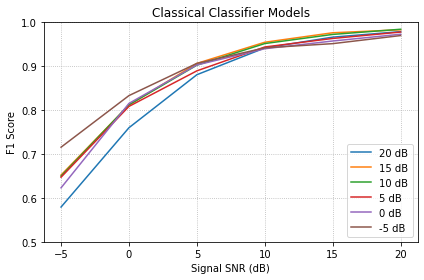

In [ ]:
model_snrs = [20, 15, 10, 5, 0, -5]
test_snrs = [20, 15, 10, 5, 0, -5]


f1_scores = {}
for model_snr in model_snrs:
    target = {}
    predicted = {}
    probabilities = {}

    for idx, snr in enumerate(test_snrs):
        conf = {}
        conf['f_s'] = 10_000
        conf['SNR'] = snr
        conf['batch_size'] = 8
        conf['epochs'] = 10
        conf['learning_rate'] = 0.0005
        conf['plot_confusion'] = True
        conf['model_path'] = f"{model_path}/classical-data-model-{model_snr}.pt"

        testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
        testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
        testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

        net = ClassicalRadarClassifier(conf).to(device)
        net.load_state_dict(torch.load(conf['model_path']))
        net.eval()

        correct = 0
        total = 0
        testloss = 0
        loss_fn = nn.CrossEntropyLoss().to(device)
        confm = np.zeros((2, 2), dtype=int)

        target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

    f1_scores[model_snr] = calc_model_f1_scores(predicted, target)


fig = plt.figure(figsize=(6.0, 4.0), dpi=72)
ax = fig.add_subplot(111)
ax.grid(linestyle=':')
ax.grid(which='both', axis='x', linestyle=':')
_ = ax.set_ylim([0.5, 1.0])
ax.set_title("Classical Classifier Models")
ax.set_xlabel("Signal SNR (dB)")
ax.set_ylabel("F1 Score")
for model_snr, snr_dict in f1_scores.items():
    _ = ax.plot(snr_dict.keys(), snr_dict.values(), label=f"{model_snr} dB")
_ = ax.legend()
fig.tight_layout()
plt.savefig(f"{plot_path}/classical_classifier_f1_scores.eps")


### Generate an Ensemble of Model Evaluations

In [ ]:
import json

data_dir = "test_sets/two_sided"
model_snr = 5
test_snrs = [20, 15, 10, 5, 0, -5]
test_datasets = ["testset_0", "testset_1", "testset_2", "testset_3", "testset_4"]

print(f"Calculating F1 score ensemble for model SNR = {model_snr}")

f1_scores = {}
for test_dataset in test_datasets:
    target = {}
    predicted = {}
    probabilities = {}

    print(f"  Calculating F1 scores for testset = '{test_dataset}'")

    for idx, snr in enumerate(test_snrs):
        conf = {}
        conf['f_s'] = 10_000
        conf['SNR'] = snr
        conf['batch_size'] = 8
        conf['epochs'] = 10
        conf['learning_rate'] = 0.0005
        conf['plot_confusion'] = True
        conf['model_path'] = f"{model_path}/classical-data-model-{model_snr}.pt"

        #print(f"    Calculating F1 scores for signal SNR = {snr}")
        testset_root = f"{radar_path}/{data_dir}/{test_dataset}/{conf['f_s']}fs/{conf['SNR']}SNR"
        testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
        testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

        net = ClassicalRadarClassifier(conf).to(device)
        net.load_state_dict(torch.load(conf['model_path']))
        net.eval()

        correct = 0
        total = 0
        testloss = 0
        loss_fn = nn.CrossEntropyLoss().to(device)
        confm = np.zeros((2, 2), dtype=int)

        target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

    f1_scores[test_dataset] = calc_model_f1_scores(predicted, target)

f1_scores_file = f"{plot_path}/classical_model_snr{model_snr}_ensemble_f1_scores.json"
with open(f1_scores_file, 'w') as fd:
    json.dump(f1_scores, fd)

snr_list = [[snr for snr in d.keys()] for d in f1_scores.values()][0]
f1_arrays = [np.array(l) for l in [[d[snr] for d in f1_scores.values()] for snr in snr_list]]
f1_means = [np.mean(f1_array) for f1_array in f1_arrays]
f1_stddevs = [np.std(f1_array) for f1_array in f1_arrays]

print("\n\n")
print(f"  Classical Classifier for {model_snr}dB")
print("  SNR   Mean F1  F1 Std. dev.")
print("-----------------------------")
for i, snr in enumerate(snr_list):
    print(f"{snr:>5}: {f1_means[i]:7.3f}  {f1_stddevs[i]:9.6f}")


Calculating F1 score ensemble for model SNR = 5
  Calculating F1 scores for testset = 'testset_0'
  Calculating F1 scores for testset = 'testset_1'
  Calculating F1 scores for testset = 'testset_2'
  Calculating F1 scores for testset = 'testset_3'
  Calculating F1 scores for testset = 'testset_4'



  Classical Classifier for 5dB
  SNR   Mean F1  F1 Std. dev.
-----------------------------
   20:   0.979   0.002569
   15:   0.969   0.004306
   10:   0.946   0.002035
    5:   0.899   0.005472
    0:   0.811   0.008772
   -5:   0.646   0.009831
